# SVM

In [1]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords

# Load the dataset
df = pd.read_csv('reviews.csv')

# Define a function to clean the text
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize the text
    words = text.split()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Join the words back into a cleaned sentence
    cleaned_text = ' '.join(words)
    return cleaned_text

# Apply the clean_text function to the 'Review' column
df['Review'] = df['Review'].apply(clean_text)

# Display the cleaned DataFrame
print(df.head())


   Id                                             Review  Label
0   0                                   good interesting      5
1   1  class helpful currently im still learning clas...      5
2   2  likeprof tas helpful discussion among students...      5
3   3  easy follow includes lot basic important techn...      5
4   4      really nice teacheri could got point eazliy v      4


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['Review'], df['Label'], test_size=0.2, random_state=42)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # You can adjust the max_features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train an SVM classifier
svm_classifier = SVC(kernel='linear')  # You can choose different kernels like 'linear', 'rbf', etc.
svm_classifier.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_rep)


Accuracy: 0.7689216968790881
Classification Report:
              precision    recall  f1-score   support

           1       0.53      0.36      0.43       493
           2       0.41      0.11      0.17       484
           3       0.29      0.09      0.14       933
           4       0.49      0.16      0.24      3613
           5       0.80      0.98      0.88     15881

    accuracy                           0.77     21404
   macro avg       0.50      0.34      0.37     21404
weighted avg       0.71      0.77      0.71     21404



# CNN

In [3]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical

# Load data
data = pd.read_csv("reviews.csv")

# Preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        words = word_tokenize(text)
        words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
        cleaned_text = ' '.join(words)
        return cleaned_text
    else:
        return ''

data['Tidy_Reviews'] = data['Review'].apply(preprocess_text)

def convert_text_to_numerical(text):
    unique_words = len(set(' '.join(data['Tidy_Reviews']).split()))
    num_words = min(7000, unique_words)
    tokenizer = Tokenizer(num_words=num_words)
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    sequence_lengths = [len(seq) for seq in sequences]
    average_length = int(sum(sequence_lengths) / len(sequence_lengths))
    maxlen = min(140, average_length * 2)
    pad_seqs = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')
    return pad_seqs, tokenizer, maxlen, num_words  # Include num_words in the return values

data = data.reset_index()
numeric_reviews, tokenizer, maxlen, num_words = convert_text_to_numerical(data['Tidy_Reviews'])
data.insert(len(data.columns)-1, "numeric_reviews", numeric_reviews.tolist())

label_encoder = LabelEncoder()
data.insert(len(data.columns), "encoded_labels", label_encoder.fit_transform(data['Label']))

# Splitting the dataset
inputs = data[['numeric_reviews']]
outputs = data[['encoded_labels']]

X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, shuffle=True, random_state=42)

X_train = np.asarray(X_train['numeric_reviews'].tolist(), dtype=np.int32)
X_test = np.asarray(X_test['numeric_reviews'].tolist(), dtype=np.int32)
y_train = np.asarray(y_train['encoded_labels'].tolist(), dtype=np.int32)
y_test = np.asarray(y_test['encoded_labels'].tolist(), dtype=np.int32)

# Building the CNN model
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=128, input_length=maxlen, trainable=True))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))  # Assuming you have 6 classes

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.1)])

# Evaluation
predicted_labels = model.predict(X_test)
predicted_classes = np.argmax(predicted_labels, axis=1)

cnn_accuracy = accuracy_score(y_test, predicted_classes)
print("Accuracy of CNN is", cnn_accuracy)


Epoch 1/10
1204/1204 [==============================] - 13s 10ms/step - loss: 0.6552 - accuracy: 0.7620 - val_loss: 0.5973 - val_accuracy: 0.7770
Epoch 2/10
1204/1204 [==============================] - 13s 11ms/step - loss: 0.5492 - accuracy: 0.7914 - val_loss: 0.6062 - val_accuracy: 0.7751
Epoch 3/10
1204/1204 [==============================] - 13s 10ms/step - loss: 0.4539 - accuracy: 0.8306 - val_loss: 0.6736 - val_accuracy: 0.7600
Epoch 4/10
669/669 [==============================] - 1s 2ms/step
Accuracy of CNN is 0.758082601382919


# Deep Learning

In [4]:
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt

# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
#from keras.preprocessing.text import Tokenizer
#from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.utils import to_categorical

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent

df = pd.read_csv('reviews.csv')

df.rename(columns = {'Review':'text', 'Label':'airline_sentiment'}, inplace = True)

df = df.reindex(np.random.permutation(df.index))  
df = df[['text', 'airline_sentiment']]

def remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
def remove_mentions(input_text):
        return re.sub(r'@\w+', '', input_text)
       
df.text = df.text.apply(remove_stopwords).apply(remove_mentions)

X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.1, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)


# Train data samples: 96316
# Test data samples: 10702


In [5]:
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

def one_hot_seq(seqs, nb_features = NB_WORDS):
    ohs = np.zeros((len(seqs), nb_features))
    for i, s in enumerate(seqs):
        ohs[i, s] = 1.
    return ohs

X_train_oh = one_hot_seq(X_train_seq)
X_test_oh = one_hot_seq(X_test_seq)

le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)

assert X_valid.shape[0] == y_valid.shape[0]
assert X_train_rest.shape[0] == y_train_rest.shape[0]

In [6]:
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(5, activation='softmax'))
base_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                640064    
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 5)                 325       
                                                                 
Total params: 644549 (2.46 MB)
Trainable params: 644549 (2.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


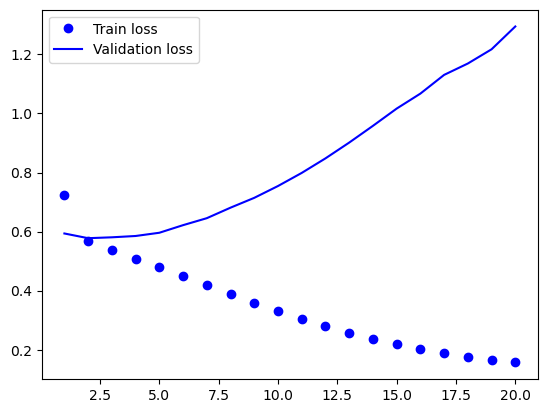

In [7]:
def deep_model(model):
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train_rest
                       , y_train_rest
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    
    return history

base_history = deep_model(base_model)

def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

eval_metric(base_history, 'loss')

In [8]:
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(32, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(5, activation='softmax'))
reduced_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 32)                320032    
                                                                 
 dense_6 (Dense)             (None, 5)                 165       
                                                                 
Total params: 320197 (1.22 MB)
Trainable params: 320197 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


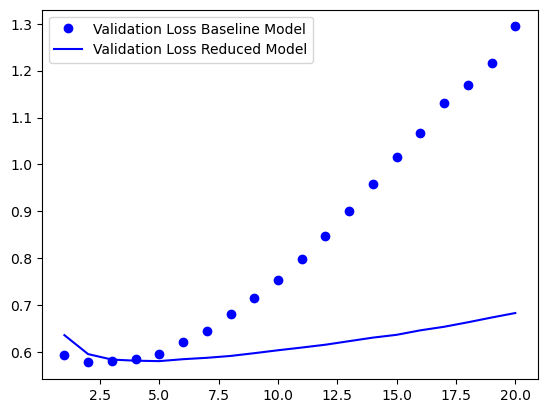

In [9]:
reduced_history = deep_model(reduced_model)

def compare_loss_with_baseline(h, model_name):
    loss_base_model = base_history.history['val_loss']
    loss_model = h.history['val_loss']

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, loss_base_model, 'bo', label='Validation Loss Baseline Model')
    plt.plot(e, loss_model, 'b', label='Validation Loss ' + model_name)
    plt.legend()
    plt.show()

compare_loss_with_baseline(reduced_history, 'Reduced Model')

In [10]:
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(5, activation='softmax'))
reg_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 64)                640064    
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 5)                 325       
                                                                 
Total params: 644549 (2.46 MB)
Trainable params: 644549 (2.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


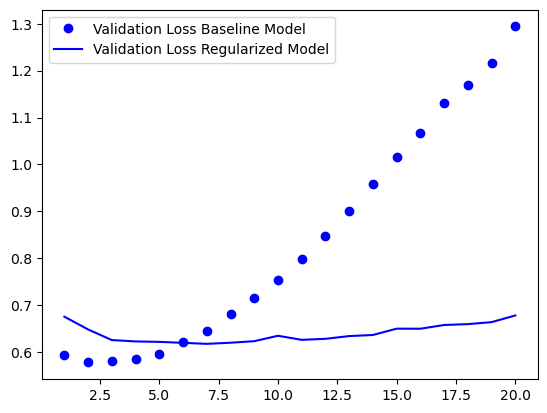

In [11]:
reg_history = deep_model(reg_model)
compare_loss_with_baseline(reg_history, 'Regularized Model')

In [12]:
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(5, activation='softmax'))
drop_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 64)                640064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 5)                 325       
                                                                 
Total params: 644549 (2.46 MB)
Trainable params: 644549 (2.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


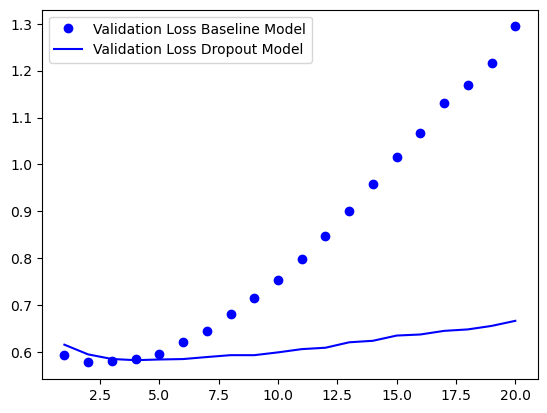

In [13]:
drop_history = deep_model(drop_model)
compare_loss_with_baseline(drop_history, 'Dropout Model')

In [ ]:
def test_model(model, epoch_stop):
    model.fit(X_train_oh
              , y_train_oh
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test_oh, y_test_oh)
    
    return results

In [14]:
base_results = test_model(base_model, 4)
print('/n')
print('Test accuracy of baseline model: {0:.2f}%'.format(base_results[1]*100))

335/335 [==============================] - 1s 2ms/step - loss: 1.3042 - accuracy: 0.7378
/n
Test accuracy of baseline model: 73.78%


In [15]:
reduced_results = test_model(reduced_model, 10)
print('/n')
print('Test accuracy of reduced model: {0:.2f}%'.format(reduced_results[1]*100))

335/335 [==============================] - 1s 2ms/step - loss: 0.6799 - accuracy: 0.7716
/n
Test accuracy of reduced model: 77.16%


In [16]:
reg_results = test_model(reg_model, 5)
print('/n')
print('Test accuracy of regularized model: {0:.2f}%'.format(reg_results[1]*100))

335/335 [==============================] - 1s 2ms/step - loss: 0.6659 - accuracy: 0.7849
/n
Test accuracy of regularized model: 78.49%


In [17]:
drop_results = test_model(drop_model, 6)
print('/n')
print('Test accuracy of dropout model: {0:.2f}%'.format(drop_results[1]*100))

335/335 [==============================] - 1s 2ms/step - loss: 0.6623 - accuracy: 0.7809
/n
Test accuracy of dropout model: 78.09%
